# Question Answering with Control

This model shows a form of question answering where statements and questions are supplied through a single 'visual input' and the replies are produced in a 'motor output' as discussed in the book. You will implement this by using the basal ganglia to store and retrieve information from working memory in response to visual input. More specifically, the basal ganglia decides what to do with the information in the visual channel based on its content (i.e. whether it is a statement or a question).


In [1]:
# Setup the environment
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import nengo
from nengo.spa import Vocabulary
from nengo.spa import BasalGanglia
from nengo.spa import Thalamus
from nengo.dists import Uniform

## Create the model

This model has parameters as described in the book. Note that in Nengo 1.4, network arrays were used to construct this model for computational reasons as explained in the book. Nengo 2.0 has 'EnsembleArray' as an equivalent to network arrays which you will use in this model. 

When you run the model, it will start by binding `RED` and `CIRCLE` and then binding `BLUE` and `SQUARE` so the memory essentially has `RED * CIRCLE + BLUE * SQUARE`. This is stored in memory because the model is told that `RED * CIRCLE` is a STATEMENT (i.e. `RED * CIRCLE + STATEMENT` in the code) as is `BLUE * SQUARE`. Then it is presented with something like `QUESTION + RED` (i.e., "What is red?"). The basal ganglia then reroutes that input to be compared to what is in working memory and the result shows up in the motor channel.

In [2]:
dim=100         # Number of dimensions 
N=30            # Neurons per dimension
N_conv=70       # Number of neurons per dimension in bind/unbind populations
N_mem=50        # Number of neurons per dimension in memory population
ZERO=[0]*dim    # Defining a zero vector having length equal to the number of dimensions

#Creating the vocabulary
rng = np.random.RandomState(15)
vocab = Vocabulary(dimensions=dim, rng=rng, max_similarity=0.05)

model = nengo.Network(label='Question Answering with Control', seed=15)
with model:
    #Ensembles
    visual = nengo.networks.EnsembleArray(n_neurons=N, n_ensembles=dim, max_rates=Uniform(100,300), label='Visual')
    channel = nengo.networks.EnsembleArray(n_neurons=N, n_ensembles=dim, label='Channel')
    motor = nengo.networks.EnsembleArray(n_neurons=N, n_ensembles=dim, label='Motor')   
    
    #Creating a memory (integrator)
    tau = 0.1
    memory = nengo.networks.EnsembleArray(n_neurons=N, n_ensembles=dim, label='Memory')
    nengo.Connection(memory.output, memory.input, synapse=tau)     
    
    #function for providing visual input
    def visual_input(t):
        if 0.1 < t < 0.3:
            return vocab.parse('STATEMENT+RED*CIRCLE').v
        elif 0.35 < t < 0.5:
            return vocab.parse('STATEMENT+BLUE*SQUARE').v
        elif 0.55 < t < 0.7:
            return vocab.parse('QUESTION+BLUE').v
        elif 0.75 < t < 0.9:
            return vocab.parse('QUESTION+CIRCLE').v
        else:
            return ZERO
        

    #function for flipping the output of the thalamus
    def xBiased(x):
        return [1-x]
     
    #Providing input to the model
    input = nengo.Node(output=visual_input, size_out=dim)
    nengo.Connection(input, visual.input)
    
    nengo.Connection(visual.output, channel.input, synapse=0.02)
    nengo.Connection(channel.output, memory.input)
    
    #Creating the unbind network
    unbind = nengo.networks.CircularConvolution(n_neurons=N_conv, dimensions=dim, invert_a=True)
    nengo.Connection(visual.output, unbind.A)
    nengo.Connection(memory.output, unbind.B)
    nengo.Connection(unbind.output, motor.input)
    
    #Creating the basal ganglia and the thalamus network
    BG = nengo.networks.BasalGanglia(dimensions=2)  
    thal = nengo.networks.Thalamus(dimensions=2)
    nengo.Connection(BG.output, thal.input, synapse=0.01)
    
    #Defining the transforms for connecting the visual input to the BG
    trans0 = np.matrix(vocab.parse('STATEMENT').v)
    trans1 = np.matrix(vocab.parse('QUESTION').v)
    nengo.Connection(visual.output, BG.input[0], transform=trans0)
    nengo.Connection(visual.output, BG.input[1], transform=trans1) 
    
    #Connecting thalamus output to the two gates gating the channel and the motor populations
    passthrough = nengo.Ensemble(n_neurons=N, dimensions=2)
    nengo.Connection(thal.output, passthrough)
 
    gate0 = nengo.Ensemble(N, 1, label='Gate0')
    nengo.Connection(passthrough[0], gate0, function=xBiased, synapse=0.01)    
    gate1 = nengo.Ensemble(N, 1, label='Gate1')
    nengo.Connection(passthrough[1], gate1, function=xBiased, synapse=0.01)
    
    for ensemble in channel.ea_ensembles:
        nengo.Connection(gate0, ensemble.neurons, transform=[[-3]] * gate0.n_neurons)
        
    for ensemble in motor.ea_ensembles:
        nengo.Connection(gate1, ensemble.neurons, transform=[[-3]] * gate1.n_neurons) 
      

## Add Probes to Collect Data

In [3]:
with model:
    Visual_p = nengo.Probe(visual.output, synapse=0.03)
    Motor_p = nengo.Probe(motor.output, synapse=0.03)
    Memory_p = nengo.Probe(memory.output, synapse=0.03)

## Run The Model

In [4]:
sim = nengo.Simulator(model)  # Create the simulator
sim.run(1.2)                  # Run it for 1.2 seconds

## Plot The Results

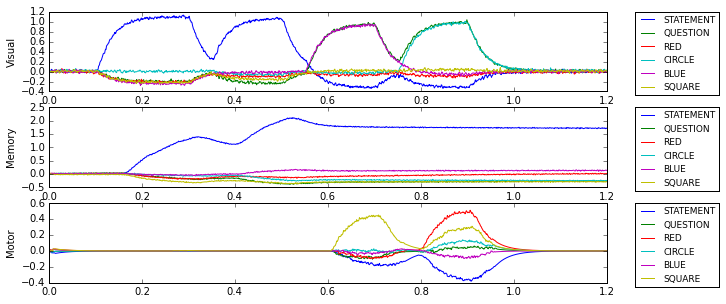

In [5]:
plt.figure(figsize=(10, 10))

plt.subplot(6, 1, 1)
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[Visual_p], vocab))
plt.legend(vocab.keys, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=9)
plt.ylabel("Visual");

plt.subplot(6, 1, 2)
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[Memory_p], vocab))
plt.legend(vocab.keys, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=9)
plt.ylabel("Memory");

plt.subplot(6, 1, 3)
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[Motor_p], vocab))
plt.legend(vocab.keys, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=9)
plt.ylabel("Motor");

The graphs above show that when the input to the Visual system is a `STATEMENT`, there is no response from the Motor system and the input is stored in the Memory. However, when the input to the Visual system is a `QUESTION`, the Motor system responds with the appropriate answer. For instance, when the input to Visual system is `CIRCLE` the output from the motor system is `RED`.

## Create the model using the `spa` package

In [16]:
import nengo
import nengo.spa as spa
from nengo.spa import Vocabulary
import numpy as np

D = 32  # the dimensionality of the vectors
rng = np.random.RandomState(15)
vocab = Vocabulary(dimensions=D, rng=rng, max_similarity=0.1)

#Adding semantic pointers to the vocabulary
CIRCLE=vocab.parse('CIRCLE')
BLUE=vocab.parse('BLUE')
RED=vocab.parse('RED')
SQUARE=vocab.parse('SQUARE')
ZERO=vocab.add('ZERO', [0]*D)

model = spa.SPA(label="Question Answering with Control", vocabs=[vocab])
with model:
    
    model.visual = spa.State(D)
    model.motor = spa.State(D)
    model.memory = spa.State(D, feedback=1, feedback_synapse=0.1)

    actions = spa.Actions(
        'dot(visual, STATEMENT) --> memory=visual',
        'dot(visual, QUESTION) --> motor = memory * ~visual'
        )
 
    model.bg = spa.BasalGanglia(actions)
    model.thalamus = spa.Thalamus(model.bg)

    #function for providing visual input
    def visual_input(t):
        if 0.1 < t < 0.3:
            return 'STATEMENT+RED*CIRCLE'
        elif 0.35 < t < 0.5:
            return 'STATEMENT+BLUE*SQUARE'
        elif 0.55 < t < 0.7:
            return 'QUESTION+BLUE'
        elif 0.75 < t < 0.9:
            return 'QUESTION+CIRCLE'
        else:
            return 'ZERO'
        
    
    #Inputs
    model.input = spa.Input(visual=visual_input)   

## Run the model in nengo_gui

In [ ]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "question-control.py.cfg")


Press the play button in the visualizer to run the simulation. You should see the "semantic pointer cloud" graphs as shown in the figure below.

The visual graph shows the input represented by `visual`. When this input is a STATEMENT, there is no response shown in the motor graph and the input is stored in `memory` (shown in memory graph). However, when the input to the `visual` is a QUESTION, the motor graph shows the appropriate answer. For instance, when the input to `visual`  is QUESTION+BLUE (showin in the visual graphs), the output from `motor` is SQUARE.

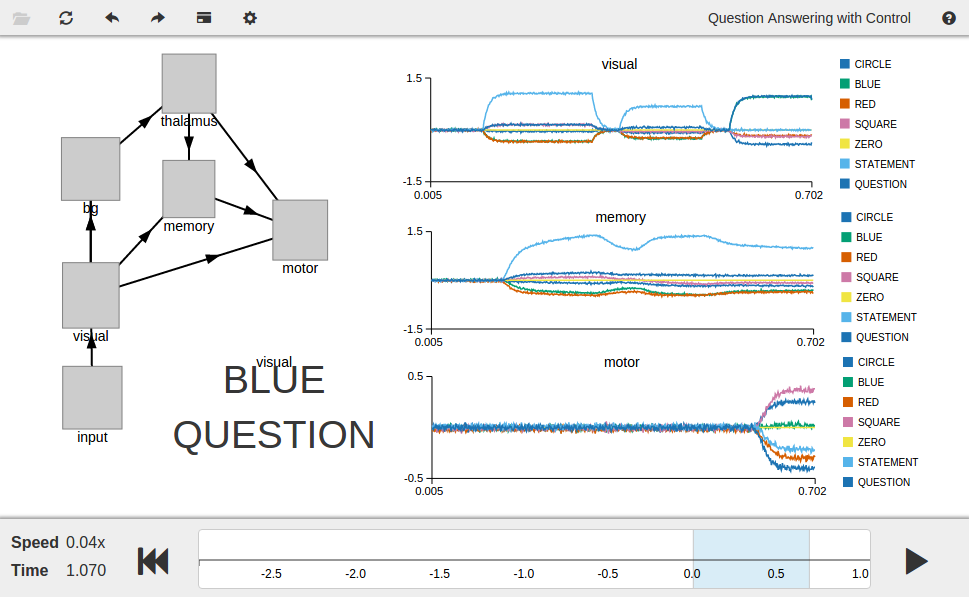

In [9]:
from IPython.display import Image
Image(filename='question-control.png')